# Анализ продаж компьютерных игр компании "Стримчик".

**Описание проекта:**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Представим, что сейчас декабрь 2016 года, и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр.

**Содержание:**
1. [Импортирование библиотек и загрузка данных](#1-импортирование-библиотек-и-загрузка-данных);
2. [Подготовка данных](#2-подготовка-данных);
3. [Исследовательский анализ данных](#исследовательский-анализ-данных);
4. [Портрет пользователя каждого региона](#портрет-пользователя-по-регионам);
   - 4.1. [Платформы по регионам](#топ-5-платформ-по-регионам)
   - 4.2. [Жанры по регионам](#жанры-по-регионам)
   - 4.3. [Влияние ESRB на продажи в отдельном регионе](#влияние-esrb-на-продажи-в-регионе)
5. [Проверка гипотез](#проверка-гипотез);
6. [Общий вывод](#общий-вывод).

## 1. Импортирование библиотек и загрузка данных

Импортируем необходимые бибилиотеки и загружаем наш датасет, сохраняем его в переменной `df`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
from scipy.stats import pearsonr

In [2]:
# загрузка данных
file_id = '1G-KJEzQrvo-hMU63mkKeBRD2omg04hM8'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

try:
    df = pd.read_csv(url)
except FileNotFoundError:
    print('File not found.')

df.head()
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
count,16713,16715,16446.000000,16713,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,10014,9949
unique,11559,31,NaN,12,NaN,NaN,NaN,NaN,NaN,96,8
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,tbd,E
freq,12,2161,NaN,3369,NaN,NaN,NaN,NaN,NaN,2424,3990
mean,NaN,NaN,2006.484616,NaN,0.263377,0.145060,0.077617,0.047342,68.967679,NaN,NaN
std,NaN,NaN,5.877050,NaN,0.813604,0.503339,0.308853,0.186731,13.938165,NaN,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,NaN,NaN


**Описание данных**

`Name` — название игры  
`Platform` — платформа  
`Year_of_Release` — год выпуска  
`Genre` — жанр игры  
`NA_sales` — продажи в Северной Америке (миллионы проданных копий)  
`EU_sales` — продажи в Европе (миллионы проданных копий)  
`JP_sales` — продажи в Японии (миллионы проданных копий)  
`Other_sales` — продажи в других странах (миллионы проданных копий)  
`Critic_Score` — оценка критиков (максимум 100)  
`User_Score` — оценка пользователей (максимум 10)  
`Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.    
Данные за 2016 год могут быть неполными.

## 2. Подготовка данных

Приведем названия столбцов к нижнему регистру.

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Преобразуем типы данных.

- `year_of_release` должен быть целым числом для корректного анализа по годам.
- `user_score` содержит строковое значение `tbd` («to be determined»), которое не является числом. Его нужно заменить на NaN, чтобы не мешать числовым операциям.
- `critic_score` уже числовой, но для надёжности также приведён к числовому типу с обработкой ошибок.

In [4]:
# year_of_release в целое число (где возможно)
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce').astype('Int64')

# user_score: заменим 'tbd' на NaN и приведём к числу
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

# critic_score уже числовой, но убедимся
df['critic_score'] = pd.to_numeric(df['critic_score'], errors='coerce')

Обработка пропусков.

- Пропуски в `year_of_release`, `critic_score`, `user_score`, `rating` — естественны: не все игры получают оценки сразу или вообще.
- `tbd` в `user_score` — это не пропуск, а отложенная оценка, которую заменили на `NaN`.

Заполнять пропуски средними или модами нецелесообразно, так как:

- Это исказит распределение оценок;
- Год выпуска нельзя «угадать»;
- Рейтинг `ESRB` не поддаётся интерполяции.

Возможные причины пропусков:

- Игры старше 2000-х часто не имеют цифровых оценок;
- Некоторые игры не прошли сертификацию ESRB;
- Данные собраны из разных источников с разной полнотой.

In [5]:
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Добавляем столбцы с суммарными продажами.

Мы сложим значения в столбцах `na_sales`,`eu_sales`,`jp_sales`,`other_sales` и сохраним в столбце `total_sales`.

In [6]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']].head()

,na_sales,eu_sales,jp_sales,other_sales,total_sales
0,41.36,28.96,3.77,8.45,82.54
1,29.08,3.58,6.81,0.77,40.24
2,15.68,12.76,3.79,3.29,35.52
3,15.61,10.93,3.28,2.95,32.77
4,11.27,8.89,10.22,1.00,31.38


Проверим наш датафрейм на наличие явных и неявных дубликатов

In [7]:
# проверка на явные дубликаты
print(f'Количество явных дубликатов в таблице = {df.duplicated().sum()}')

Количество явных дубликатов в таблице = 0


Названия игр логично могут совпадать и продаваться на разные платформы, а вот совпадения в названиях, в платформах и в годе одновременно будут неявными дубликатами в нашей таблице, поэтому найдем в каких строчках совпадают названия, платформы и год релиза.

In [8]:
# проверка на наличие неявных дубликатов
df[df.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E,2.56
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E,0.01


Неявные дубликаты мы нашли, оставим первые вхождения этих строк, но прибавим разницу что бы не выкинуть случайно 0.03 млн копий.

In [9]:
# обработка пары 604 - 16230
df.loc[604, 'eu_sales'] += df.loc[16230, 'eu_sales']
df.loc[604, 'total_sales'] += df.loc[16230, 'total_sales']

# Обработка пары 659 - 14244
df.loc[659, 'jp_sales'] += df.loc[14244, 'jp_sales']
df.loc[659, 'total_sales'] += df.loc[14244, 'total_sales']

# удаляем дубликаты (строки 16230 и 14244)
df = df.drop(index=[16230, 14244]).reset_index(drop=True)

# проверяем результаты
print(df.loc[[604, 659], ['name', 'platform', 'year_of_release', 'eu_sales', 'jp_sales', 'total_sales']])

              name platform  year_of_release  eu_sales  jp_sales  total_sales
604  Madden NFL 13      PS3             2012      0.23      0.00         2.57
659            NaN      GEN             1993      0.53      0.03         2.42


Результаты совпали, предобработка выполнена

## Исследовательский анализ данных

В рамках исследовательского анализа данных я будет необходимо выполнить ряд задач и ответить на выпросы. Задачи перед нами стоят слудющие:

1. Посмореть сколько игр выпускалось в разные годы;
2. Посмотреть как менялись продажи по платформам и выделить Топ платформ по суммарным продажам;
3. Необходимо выбрать *актуальный период* что бы построить прогноз на 2017 год;
4. Выбрать потенциально прибыльные платформы;
5. Проанализировать глобальные продажи игр в разбивке по платформам;
6. Проанализировать влияние оценок пользователей и критиков на продажи игр (внутри крупной платформы);
7. Оценить общее распределение игр по жанрам.

**Количество выпущенных игр по годам**

Рассмотрим общуюю динамику выпуска игр без разбивки на платформы.

In [10]:
# создаем интерактивный график
fig = px.line(
    df.groupby(
        'year_of_release'
        )['name'].count().reset_index(),
        x='year_of_release',
        y='name',
        title='Количество выпущенных игр по годам',
        labels={'year_of_release':'Год','name':'Количество игр'})


games_count = df['name'].count()
total_sales_sum = df['total_sales'].sum()


# укажем также общую сумму продаж и количество за все время
print(f'Количество игр за все время = {games_count}')
print(f'Общая сумма продаж за все время {total_sales_sum:.0f}')

fig.show()

Количество игр за все время = 16712
Общая сумма продаж за все время 8916


За весь период времени было выпущено больше 16 тысяч игр, больше всего игр было выпущено в 2008 (1427), до этого года мы наблюдали общий подъем в количестве, однако после 2009 года начался спад и в 2015 году показатель был на уровне 2001 года.

**Продажи по платформам и Топ платформ.**

In [11]:
# сформируем Топ платформ
top_platforms = (
    df.groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)
#top_platforms

print("Топ-10 платформ по суммарным продажам:")
print(df.groupby('platform')['total_sales'].sum().loc[top_platforms])

Топ-10 платформ по суммарным продажам:
platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: total_sales, dtype: float64


Визуализируем продажи Топ платформ по годам.

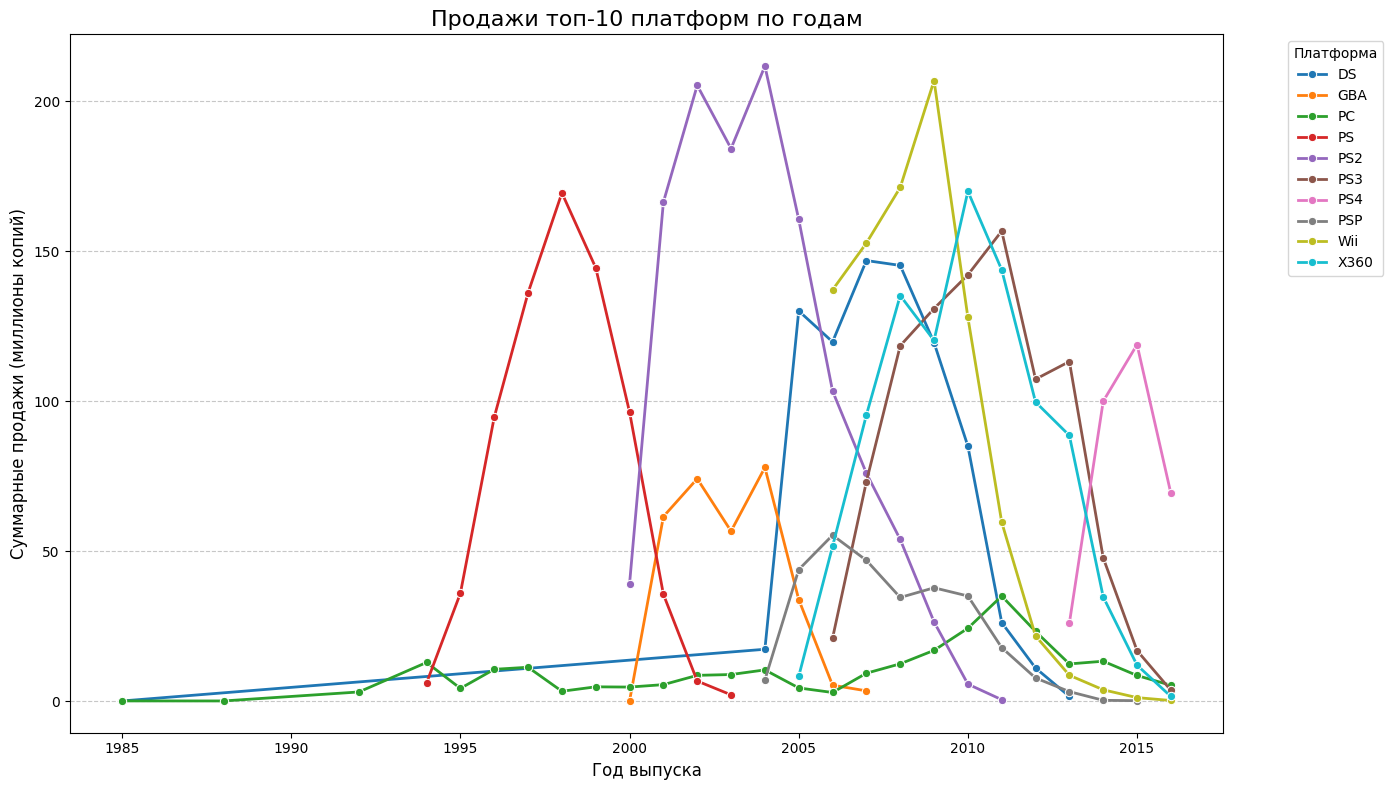

In [12]:
top_platforms_data = df[df['platform'].isin(top_platforms)]

# формируем продажи по годам
sales_by_year = (
    top_platforms_data
    .groupby(['platform', 'year_of_release'])['total_sales']
    .sum()
    .reset_index()
)

# строим график
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=sales_by_year,
    x='year_of_release',
    y='total_sales',
    hue='platform',
    marker='o',
    linewidth=2
)
plt.title('Продажи топ-10 платформ по годам', fontsize=16)
plt.xlabel('Год выпуска', fontsize=12)
plt.ylabel('Суммарные продажи (миллионы копий)', fontsize=12)
plt.legend(title='Платформа', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Мы сформировали Топ платформ по продажам за все время.

Из-за очень длинного промежутка лет неудобно проводить анализ, поэтому ограничимся **актуальным периодом** (*период лет, данные за который помогут построить прогноз на 2017 год*)

В качестве актуального периода выберим период с 2014 по 2016 год. Потому что индустрия компьютерных игр быстро меняется и стоит ограничится промежутком от 3 до 5 лет.

Продажи Топ платформ за актуальный период


platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: total_sales, dtype: float64

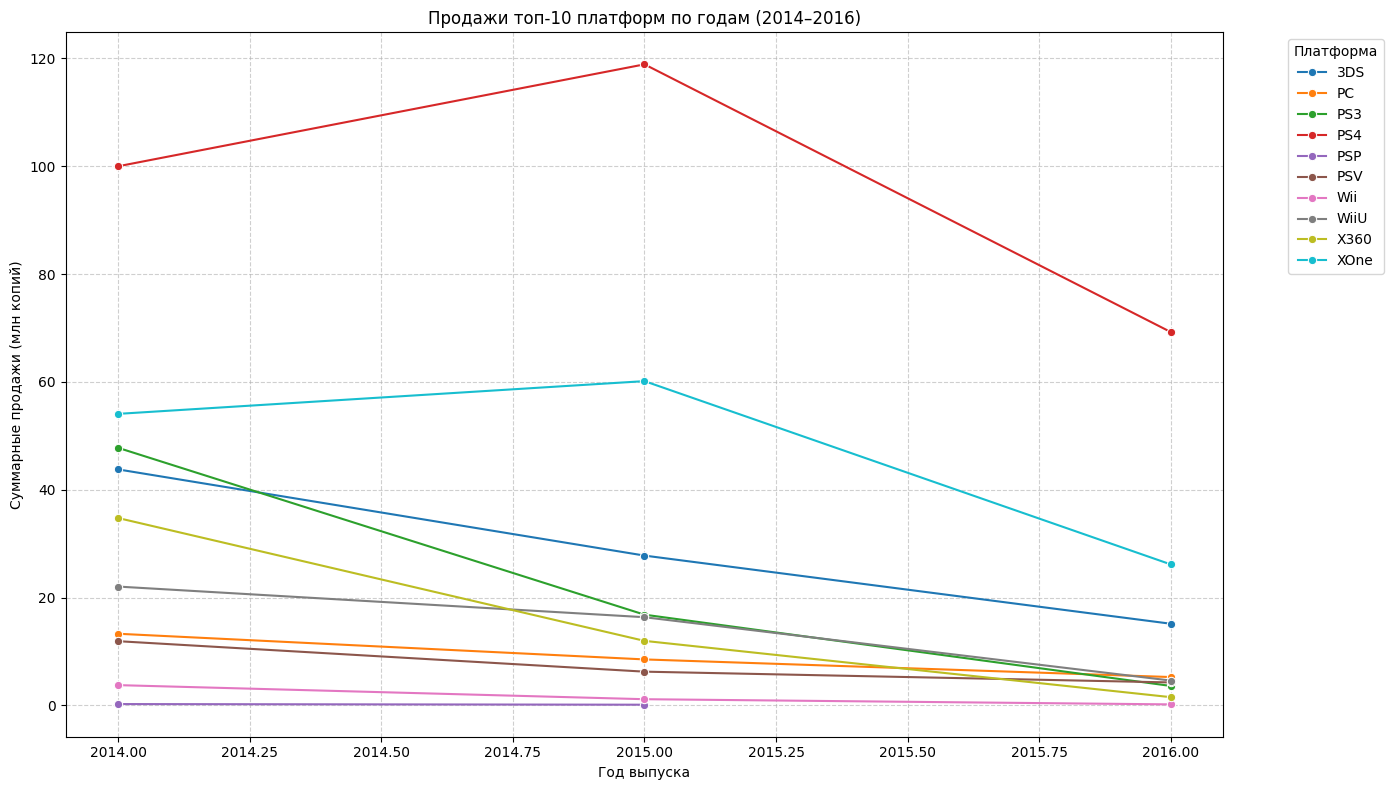

In [13]:
# фильтруем актуальный период
df_actual = df[(df['year_of_release']>=2014) & (df['year_of_release']<=2016)].copy()

# считаем Топ за актуальный период
top_platforms = (
    df_actual.groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

df_top = df_actual[df_actual['platform'].isin(top_platforms)]
sales_by_year = df_top.groupby([
    'year_of_release', 
    'platform'])[
        'total_sales'
        ].sum().reset_index()

print('Продажи Топ платформ за актуальный период')
display(df_top.groupby('platform')['total_sales'].sum().sort_values(ascending=False))

# график
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=sales_by_year, 
    x='year_of_release', 
    y='total_sales', 
    hue='platform', 
    marker='o'
)
plt.title('Продажи топ-10 платформ по годам (2014–2016)')
plt.xlabel('Год выпуска')
plt.ylabel('Суммарные продажи (млн копий)')
plt.legend(title='Платформа', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Часть компаний из Топа за все время вышли из Топа за актуальный период. Лидерами за период в 6 лет стали следующие платформы: PS3,X360,PS4,3DS,Wii,XOne,DS,PC,WiiU,PSP. 

Наблюдая за динамикой продаж по платформам за все время, можно увидеть что большая часть компаний достигают пика своей популярности в начале и стремятся к минимуму. На основе имеющихся данных можно определить срок жизни платформ, для этого посмотрим как долго платформы остаются на пике после своего появления.

In [14]:
# найдём первый и последний год активности каждой платформы (в 2014–2016)
lifespan = df_actual.groupby('platform')['year_of_release'].agg(['min', 'max'])
lifespan['lifespan'] = lifespan['max'] - lifespan['min']

print("\nХарактерный срок жизни платформ (завершивших цикл к 2016):")
print(f"Среднее: {lifespan['lifespan'].mean():.1f} лет")
print(f"Медиана: {lifespan['lifespan'].median():.1f} лет")


Характерный срок жизни платформ (завершивших цикл к 2016):
Среднее: 1.9 лет
Медиана: 2.0 лет


Периоды активности платформ:


,min,max,count,lifetime_years
platform,,,,
PC,1985,2016,957,32
DS,1985,2013,2121,29
GB,1988,2001,97,14
NES,1983,1994,98,12
X360,2005,2016,1232,12
PS2,2000,2011,2127,12
PSP,2004,2015,1193,12
DC,1998,2008,52,11
PS3,2006,2016,1305,11


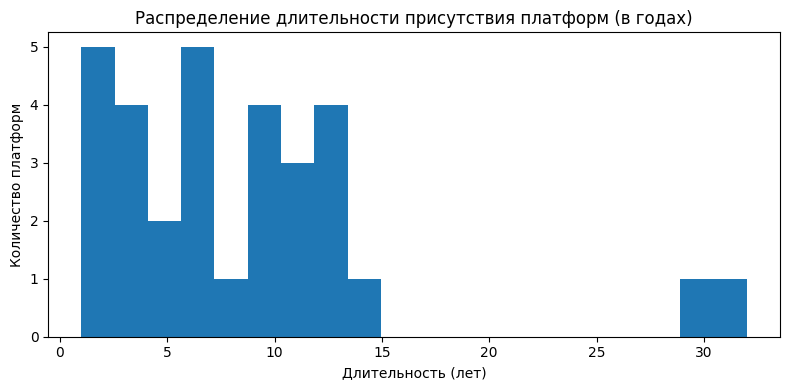

In [15]:
platform_lifetimes = df.groupby('platform')['year_of_release'].agg(['min','max','count']).sort_values('min')
platform_lifetimes['lifetime_years'] = platform_lifetimes['max'] - platform_lifetimes['min'] + 1
print("Периоды активности платформ:")
display(platform_lifetimes.sort_values(by='lifetime_years',ascending=False).head(20))

# посмотрим распределение длительностей платформ
plt.figure(figsize=(8,4))
plt.hist(platform_lifetimes['lifetime_years'].dropna(), bins=20)
plt.title("Распределение длительности присутствия платформ (в годах)")
plt.xlabel("Длительность (лет)")
plt.ylabel("Количество платформ")
plt.tight_layout()
plt.show()

Посмотрим на ящик с усами по глобальным продажам игр в разбивке по платформам.

Оставим только платформы с количеством игр больше 10 за актуальный период, иначе рискуем столкнутся с выбросами на малоактивных платформах.

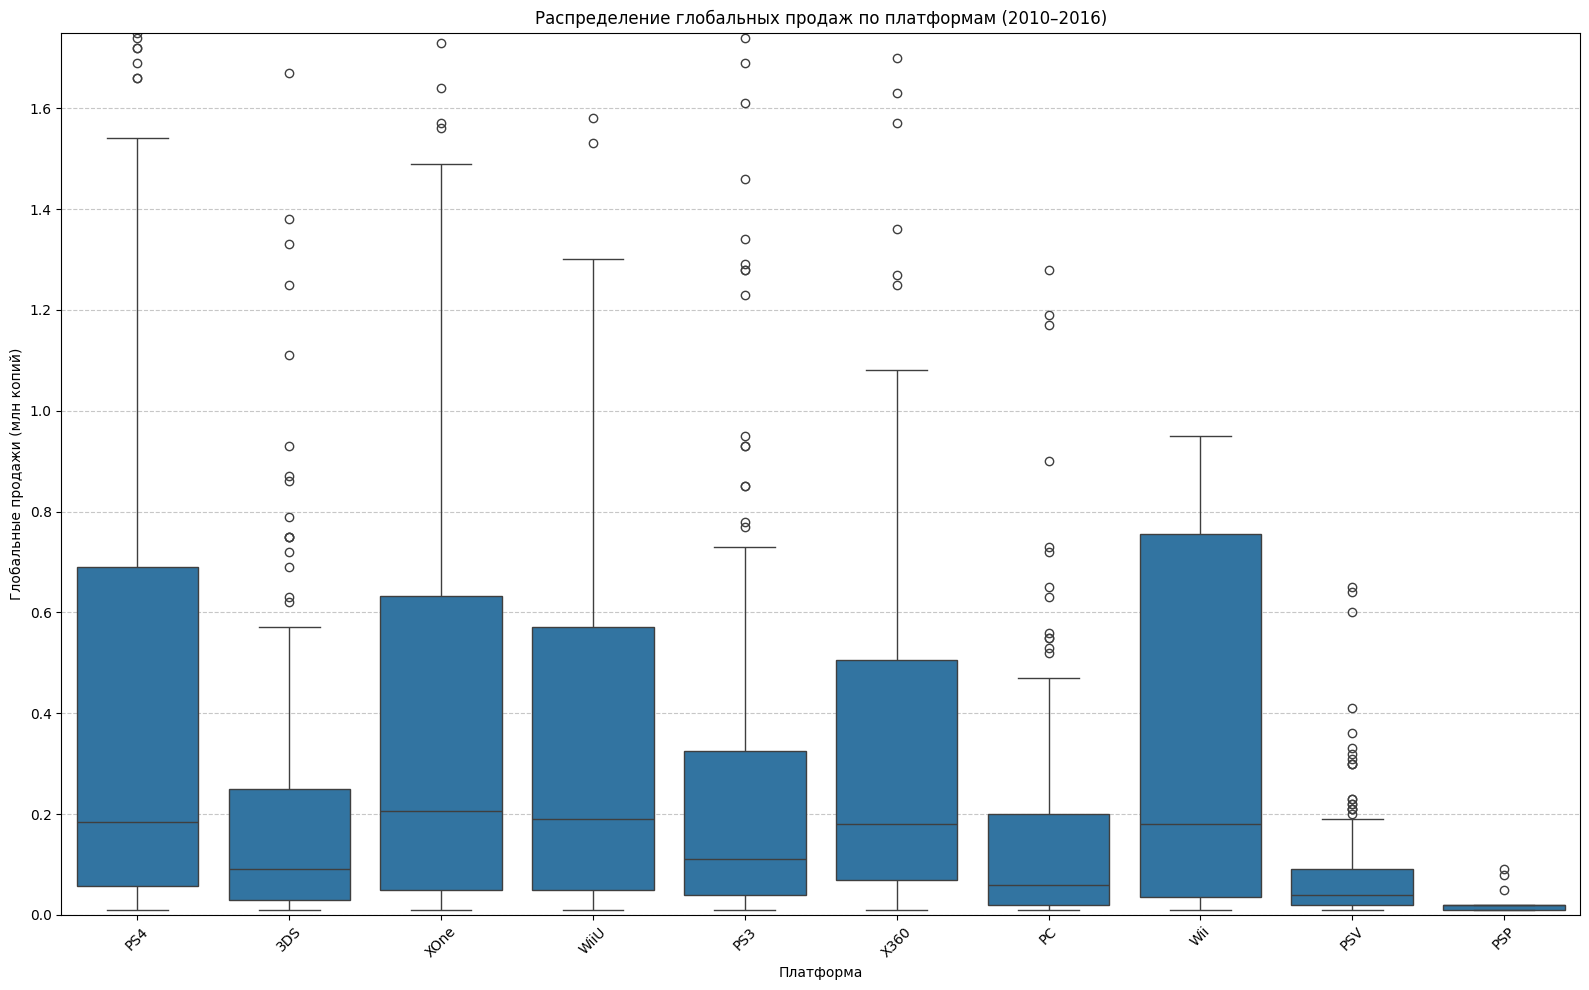

In [16]:
platform_counts = df_actual['platform'].value_counts()
platforms_to_plot = platform_counts[platform_counts > 10].index
df_filtered = df_actual[df_actual['platform'].isin(platforms_to_plot)]

# убедимся, что total_sales не содержит отрицательных или некорректных значений
df_filtered = df_filtered[df_filtered['total_sales'] >= 0]

# строим график
plt.figure(figsize=(16, 10))
sns.boxplot(data=df_filtered, x='platform', y='total_sales')
plt.title('Распределение глобальных продаж по платформам (2010–2016)')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи (млн копий)')
plt.ylim(0, 1.75)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**ПРОМЕЖУТОЧНЫЙ ВЫВОД**:

Анализ продаж по платформам за актуальный период (2010–2016 гг.), релевантный для прогноза на 2017 год, показал, что **лидерами стали PS3, X360, PS4, 3DS, Wii, XOne, DS, PC, WiiU и PSP** — то есть платформы нового поколения, доминировавшие в 2010-х годах. При этом часть исторически успешных платформ (например, PS2, NES и др.) уже не входят в топ за этот период, что подчеркивает смену технологических поколений.

Динамика продаж по платформам **демонстрирует четкий жизненный цикл**: после выхода на рынок платформа быстро набирает популярность, достигает пика продаж и затем постепенно уступает место новым решениям.

На основе данных по платформам, завершившим свой жизненный цикл к 2016 году, установлен характерный срок жизни — **около 4/5 лет**. Это означает, что платформа в среднем остаётся коммерчески актуальной не более 6 лет после выхода на пик продаж, после чего её доля на рынке резко снижается.

Для всех платформ наблюдается большое количество выбросов (отдельных игр, продающихся более 1 млн копий), что говорит о том, что рынок игры — это рынок хитов.
Большинство игр (медианы и нижние квартили) продаются в количестве менее 0.5 млн копий, а часто — менее 0.2 млн.  


Таким образом, для построения прогноза на 2017 год **следует ориентироваться на платформы, находящиеся в фазе роста или пика в 2014–2016 гг.**, такие как PS4, XOne и 3DS, поскольку они наиболее вероятно сохранят значимость в ближайшем будущем.

PS4, XOne, PS3, X360 имеют наиболее высокие медианы и расширенные верхние квартили, что указывает на их способность регулярно выпускать успешные проекты.

Это подтверждает, что платформы нового поколения (PS4, XOne) являются наиболее стабильными и прибыльными для издателей в этот период.

**Влияние оценки пользователей и критиков на продажи внутри одной платформы.**

Для анализа возьмем платформу PS4, как одну из перспективных.

- Отфильтруем данные по PS4 за 2014–2016 гг.
- Удалим игры без оценок критиков (Critic_Score) и пользователей (User_Score).
- Построим два scatter plot'а: один для оценок критиков, другой для оценок пользователей.
- Рассчитаем коэффициенты корреляции Пирсона.
- Сформулируем выводы.

In [17]:
# фильтруем данные за актуальный период для PS4
df_ps4 = df[(df['platform'] == 'PS4') & (df['year_of_release'] >= 2014) & (df['year_of_release'] <= 2016)].copy()

# Удаляем строки, где нет ни продаж, ни оценок
df_ps4_clean = df_ps4.dropna(subset=['total_sales', 'critic_score', 'user_score'])

print(f"Количество игр для анализа: {len(df_ps4_clean)}")

Количество игр для анализа: 234


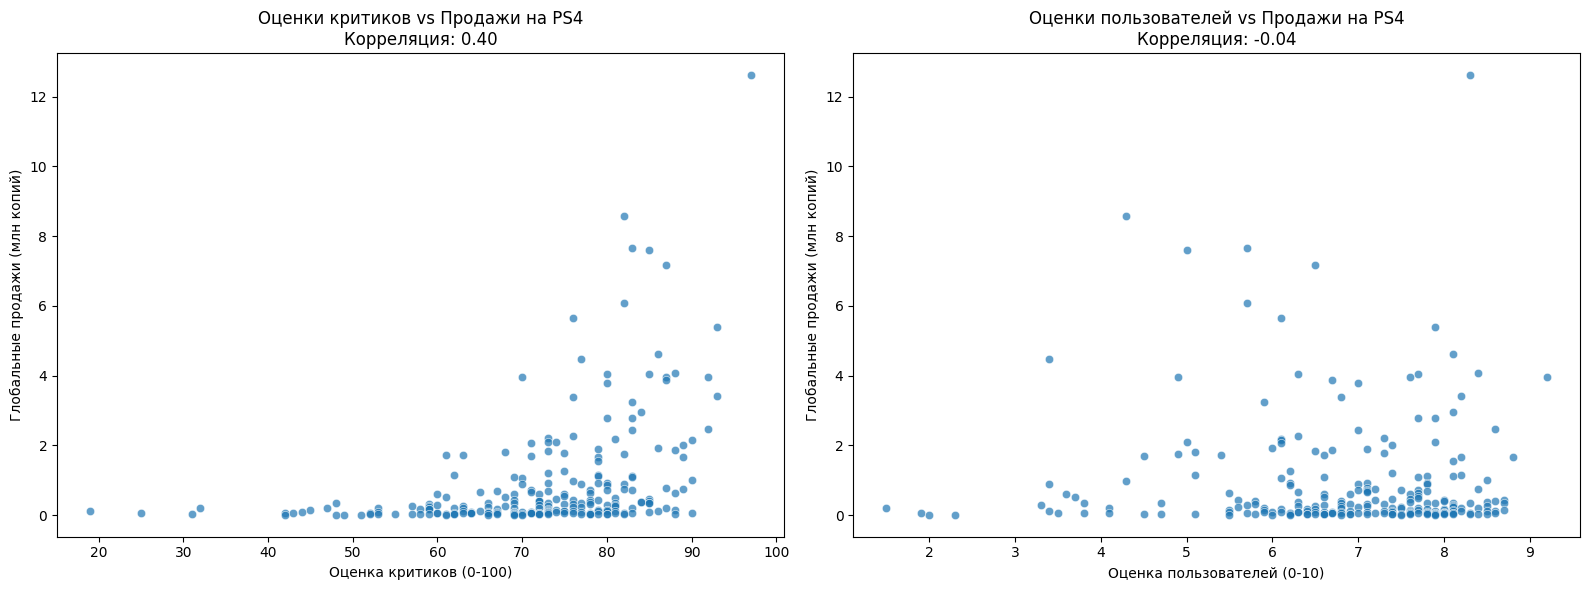

Корреляция с оценками критиков: 0.402 (p-value: 0.000)
Корреляция с оценками пользователей: -0.043 (p-value: 0.511)


In [18]:
# рассчитываем корреляцию
critic_corr, critic_p = pearsonr(df_ps4_clean['critic_score'], df_ps4_clean['total_sales'])
user_corr, user_p = pearsonr(df_ps4_clean['user_score'], df_ps4_clean['total_sales'])

# строим графики
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# график для оценок критиков
sns.scatterplot(data=df_ps4_clean, x='critic_score', y='total_sales', ax=axes[0], alpha=0.7)
axes[0].set_title(f'Оценки критиков vs Продажи на PS4\nКорреляция: {critic_corr:.2f}')
axes[0].set_xlabel('Оценка критиков (0-100)')
axes[0].set_ylabel('Глобальные продажи (млн копий)')

# график для оценок пользователей
sns.scatterplot(data=df_ps4_clean, x='user_score', y='total_sales', ax=axes[1], alpha=0.7)
axes[1].set_title(f'Оценки пользователей vs Продажи на PS4\nКорреляция: {user_corr:.2f}')
axes[1].set_xlabel('Оценка пользователей (0-10)')
axes[1].set_ylabel('Глобальные продажи (млн копий)')

plt.tight_layout()
plt.show()

print(f"Корреляция с оценками критиков: {critic_corr:.3f} (p-value: {critic_p:.3f})")
print(f"Корреляция с оценками пользователей: {user_corr:.3f} (p-value: {user_p:.3f})")

**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**

По полученным данным можно утверждать что есть умеренная положитеьная связь между оценками критиков и продажами внутри платформы PS4. Чем выше оценка критиков тем, в среднем, выше продажи игр.

А между оценками пользователей и продажами нутри платформы PS4 связи нет.

Сравним выводы с показателями по остальным платформам:

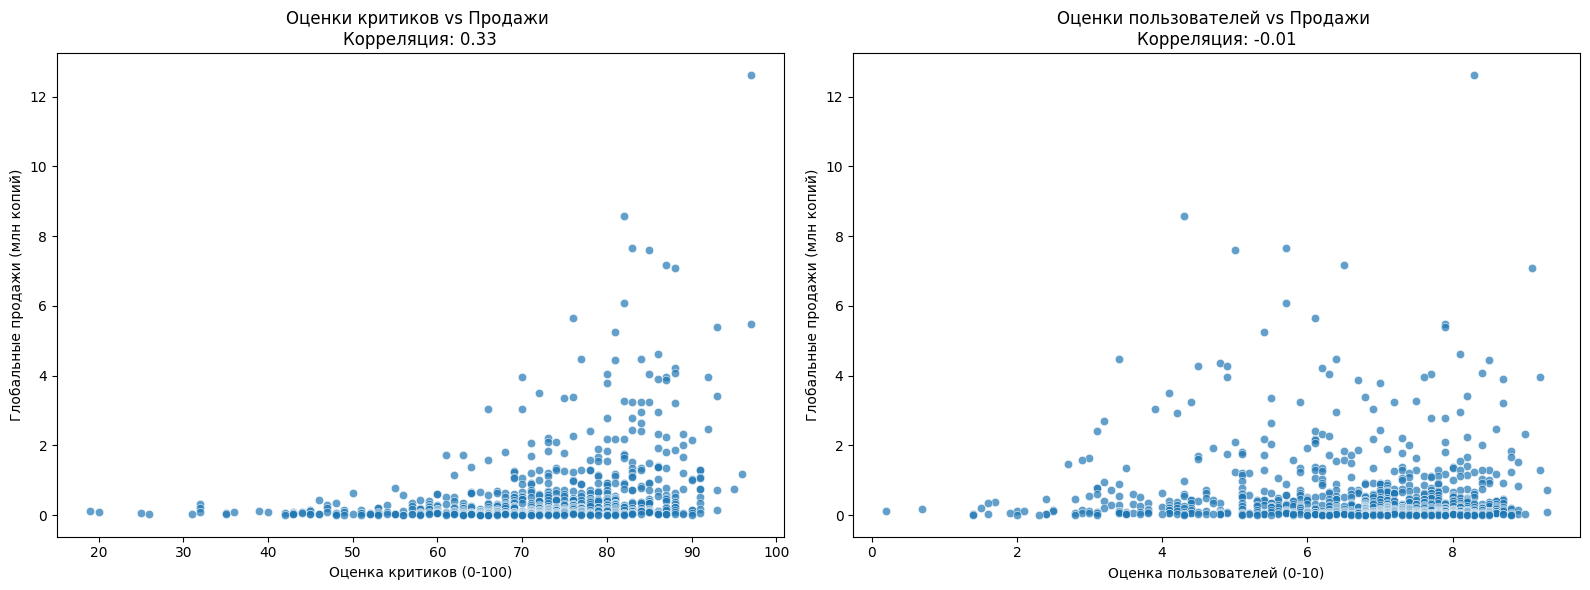


Корреляция критиков (все платформы, актуальный период): 0.3281
Корреляция пользователей (все платформы, актуальный период): -0.0131


In [19]:

corr_all_critic = df_actual['critic_score'].corr(df_actual['total_sales'])
corr_all_user = df_actual['user_score'].corr(df_actual['total_sales'])


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df_actual, x='critic_score', y='total_sales', ax=axes[0], alpha=0.7)
axes[0].set_title(f'Оценки критиков vs Продажи \nКорреляция: {corr_all_critic:.2f}')
axes[0].set_xlabel('Оценка критиков (0-100)')
axes[0].set_ylabel('Глобальные продажи (млн копий)')

# график для оценок пользователей
sns.scatterplot(data=df_actual, x='user_score', y='total_sales', ax=axes[1], alpha=0.7)
axes[1].set_title(f'Оценки пользователей vs Продажи \nКорреляция: {corr_all_user:.2f}')
axes[1].set_xlabel('Оценка пользователей (0-10)')
axes[1].set_ylabel('Глобальные продажи (млн копий)')

plt.tight_layout()
plt.show()

print(f"\nКорреляция критиков (все платформы, актуальный период): {corr_all_critic:.4f}")
print(f"Корреляция пользователей (все платформы, актуальный период): {corr_all_user:.4f}")

**Промежуточный вывод:**

Как и с продажами внутри одной платформы, так и в сравнении со всеми показателями, наблюдается слабая положительная связь между оценками критиков и общими продажами. То есть чем лучше критики оценивают игру, тем выше продажи этой игры. 

Между оценками пользователей и продажами - значимой связи нет.

**Общее распределение игр по жанрам.**

Выделим прибыльные жанры и рассмотрим общее распределение по жанрам.

In [20]:
# выделим сначала игр какого жанра больше всего
genre_prod = df_actual.groupby(
    'genre')[
        'name'
        ].count().sort_values(ascending=False).reset_index()

fig = px.bar(
    genre_prod,
    x='genre',
    y='name',
    color='genre',
    labels={'genre':'Жанры','name':'Количество выпущенных игр'},
    title='Количество выпущенных игр по жанрам (2014 - 2016)',
    text='name'
)

fig.show()

Чаще всего (за актуальный период) выпускались игры в жанре `Action`, в первую пятерку также попали `Misc`, `Sports`, `Role-Playing` и `Adventure`.

Рассмотрим продажи по жанрам и выделим самые прибыльные.

In [21]:
# распределение игр по жанрам
genre_sales = df_actual.groupby(
    'genre')['total_sales'].agg([
        'mean', 
        'median', 
        'sum']).sort_values(by='sum', ascending=False).reset_index()

fig = px.bar(
    genre_sales, 
    x= 'genre', 
    y='sum', 
    color='genre', 
    labels={
        'genre':'Жанр игр', 
        'sum':'Сумма продаж'
        }, 
    title='Продажи игр по жанрам (2014 - 2016)'
    )
fig.show()

Для полноты исследования, необходимо также рассмотреть средние продажи и медианну, так мы сможем найти стабильно прибыльные жанры.

In [22]:
genre_sales.style.format(
    {'sum': '${:.2f}', 'mean': '${:.2f}', 'median': '${:.2f}'}
    ).bar(
        color='lightblue', 
        subset=['sum','mean','median']
)

,genre,mean,median,sum
0,Action,$0.32,$0.09,$199.36
1,Shooter,$1.34,$0.52,$170.94
2,Sports,$0.68,$0.18,$109.48
3,Role-Playing,$0.46,$0.11,$101.44
4,Misc,$0.33,$0.09,$37.55
5,Fighting,$0.47,$0.12,$28.22
6,Racing,$0.40,$0.09,$27.52
7,Platform,$0.48,$0.14,$18.09
8,Adventure,$0.09,$0.03,$17.55
9,Simulation,$0.30,$0.10,$13.13


**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**

Чаще всего платформы выпускали игры жанров `Action`, `Misc`, `Sports`, `Role-Playing` и `Adventure`, топ по покупкам меняется не сильно, однако второе место у нас занимает жанр `Shooter`, по продажам этот жанр обгоняет все кроме `Action`. Жанр `Adventure` наоборот, часто выпускался на платформах, но покупают его реже чем игры большей части жанров.

На сонове исследования можно сделать следующие выводы:

1. Action-игры - идеальный выбор для максимизации прибыли (большой рынок, много игроков).
2. Shooter - хорошо подходит для минимизации рисков и достижения стабильности (высокий средний чек).
3. Sports — хороший баланс: высокая сумма + средние/медианные показатели.
4. Puzzle, Strategy, Adventure — низкие продажи → нишевые или малорентабельные жанры.

**ОБЩИЙ ВЫВОД ПО ИССЛЕДОВАТЕЛСЬКОМУ АНАЛИЗУ.**

**Динамика рынка и жизненный цикл платформ:** Анализ выявил общий спад в количестве выпускаемых игр после 2009 года. Ключевой закономерностью является жизненный цикл игровых платформ, который длится около 4-5 лет. После выхода платформа достигает пика продаж, а затем её коммерческая значимость снижается, уступая место новому поколению. Для прогноза на 2017 год релевантны платформы, находившиеся в фазе роста или пика в 2014-2016 гг.: PS4, XOne и 3DS. Именно PS4 и XOne демонстрируют наибольшую стабильность и способность регулярно выпускать успешные проекты, что делает их наиболее прибыльными и перспективными для издателей.

**Влияние оценок на продажи:** Обнаружена устойчивая, хотя и слабая, положительная связь между оценками критиков и объемами продаж. Это справедливо как для рынка в целом, так и для конкретных успешных платформ (например, PS4). В то же время статистически значимой связи между оценками пользователей и продажами не выявлено. Это указывает на то, что мнение профессиональных обозретелей является более весомым фактором коммерческого успеха, чем пользовательские рейтинги.

**Жанровая структура рынка:** На рынке доминируют жанры Action, Shooter и Sports. Несмотря на то, что игры жанра Action выпускаются чаще всего, именно жанр Shooter показывает исключительно высокую эффективность по продажам, уверенно занимая второе место. Напротив, жанр Adventure, будучи популярным у разработчиков, демонстрирует относительно низкие продажи. Таким образом, наиболее прибыльными и стабильными являются жанры Action, Shooter и Sports.

**"Хитовость" рынка:** Индустрия видеоигр является ярко выраженным "рынком хитов". Распределение продаж крайне неравномерно: в то время как большинство игр продаются тиражами менее 200-500 тысяч копий, существует значительное количество выбросов — единичных проектов, продающихся миллионными тиражами, которые и формируют основную выручку.

**Заключение:** Для достижения коммерческого успеха в 2017 году студиям и издателям следует фокусироваться на разработке и продвижении игр жанров Action, Shooter и Sports для платформ нового поколения (PS4, XOne), обеспечивая при этом высокий уровень качества, который будет положительно оценен профессиональными критиками.

## Портрет пользователя по регионам

Нам необходимо для пользователя каждого региона (за акутальный период 2014-2016) выделить:
1. Самые популярные платформы;
2. Самые популярные жанры;
3. Влияние рейтинга ESRB на продажи в регионе.

### ТОП-5 ПЛАТФОРМ ПО РЕГИОНАМ:

In [23]:
# вывод графика
def px_pltf_region(region_sales):
    '''
    Функция сначала сравнивает переменную что бы определить регион,
    далее формирует таблицу топа платформ по суммам продаж в регионе и
    выводит интерактивную столбчатую диаграмму
    '''

    if region_sales == 'na_sales':
        region = 'Северная Америка'
    elif region_sales == 'eu_sales':
        region = 'Европа'
    else:
        region = 'Япония' 


    pltf_region = df_actual.pivot_table(
        index='platform', 
        values=region_sales, 
        aggfunc='sum').sort_values(
            by=region_sales,
            ascending=False).reset_index().head()
    
    pltf_region['shape'] = (pltf_region[region_sales] / pltf_region[region_sales].sum())*100
    

    fig = px.bar(
        pltf_region, 
        x='platform', 
        y=region_sales,
        color='platform',
        labels={'platform':'Платформы', region_sales:'Продажи (млн копий)'},
        title=f'Топ-5 популярных платформ в регионе: {region}',
        text=pltf_region['shape'].apply(lambda x: '{0:1.1f}%'.format(x))
    )
    
    fig.show()

In [24]:
# топ платформ в Северной Америке
px_pltf_region('na_sales')

In [25]:
# топ платформ в Европе
px_pltf_region('eu_sales')

In [26]:
# топ платформ в Японии
px_pltf_region('jp_sales')

**ВЫВОД:**
1. Северная Америка:

Лидер — X360 (33.4%), что указывает на сильные позиции Microsoft в этом регионе.

Второе место — PS3 (24.8%).

Рынок более сбалансирован: в топ-5 входят как консоли Sony (PS3, PS4), так и Microsoft (X360, XOne), а также портативная консоль Nintendo (3DS).

2. Европа:

Чёткое доминирование Sony: PS3 (30.2%) и PS4 (26.2%) вместе занимают более половины рынка.

X360 (21.7%) существенно уступает, что подчёркивает более слабые позиции Microsoft по сравнению с Северной Америкой.

В топ-5 также входят PC (11.4%) — уникальный случай среди регионов.

3. Япония:

Абсолютное лидерство Nintendo 3DS — 47.5%, что составляет почти половину рынка.

Далее с большим отрывом идут консоли Sony: PS3 (23.3%), PSP (11.3%), PSV (10.3%) и PS4 (7.5%).

Продукты Microsoft (Xbox) полностью отсутствуют в топ-5, что демонстрирует их крайне низкую популярность в Японии.


Каждый регион имеет уникальную платформенную структуру: Северная Америка — конкурентный рынок между Sony и Microsoft, Европа — доминирование Sony, Япония — лидерство Nintendo при сильных позициях Sony и практическом отсутствии Microsoft.


### Жанры по регионам

Выделим Топ-5 жанров по продажам в каждом регионе и поясним разницу.

In [27]:
def px_genre_region(region_sales):
    '''
    Функция сначала сравнивает переменную что бы определить регион,
    далее формирует таблицу топа жанров по суммам продаж в регионе и
    выводит интерактивную столбчатую диаграмму
    '''

    if region_sales == 'na_sales':
        region = 'Северная Америка'
    elif region_sales == 'eu_sales':
        region = 'Европа'
    else:
        region = 'Япония' 


    genre_region = df_actual.pivot_table(
        index='genre', 
        values=region_sales, 
        aggfunc='sum').sort_values(
            by=region_sales,
            ascending=False).reset_index().head()
    
    genre_region['shape'] = (genre_region[region_sales] / genre_region[region_sales].sum())*100
    

    fig = px.bar(
        genre_region, 
        x='genre', 
        y=region_sales,
        color='genre',
        labels={'platform':'Платформы', region_sales:'Продажи (млн копий)'},
        title=f'Топ-5 популярных жанров в регионе: {region}',
        text=genre_region['shape'].apply(lambda x: '{0:1.1f}%'.format(x))
    )
    
    fig.show()

In [28]:
px_genre_region('na_sales')

In [29]:
px_genre_region('eu_sales')

In [30]:
px_genre_region('jp_sales')

**ВЫВОД:**

1. Северная Америка:

Лидирует жанр Action (33.6%), что указывает на предпочтение динамичных игр.

Shooter (25.3%) занимает второе место, подтверждая популярность стрелялок.

Sports (15.8%) также входит в топ, демонстрируя интерес к спортивным симуляторам.

Структура предпочтений достаточно сбалансирована без абсолютного доминирования одного жанра.

2. Европа:

Как и в Северной Америке, лидирует Action (37.0%), но с более высоким показателем.

Shooter (27.5%) сохраняет вторую позицию.

Sports (16.4%) и Racing (11.6%) показывают более высокую популярность, чем в Северной Америке.

В топ-5 уникально присутствует жанр Role-Playing (7.5%), отсутствующий в американском рейтинге.

3. Япония (кардинально отличается):

Абсолютное доминирование Role-Playing (43.0%) — почти половина рынка.

Action (34.3%) занимает второе место, но с существенным отставанием.

В топ входят нишевые для других регионов жанры: Fighting и Platform.

Полное отсутствие Shooter в топ-5, что контрастирует с западными рынками.

Европа и Северная Америка демонстрируют схожие жанровые предпочтения с доминированием Action и Shooter, в то время как японский рынок формирует уникальный спрос с абсолютным лидерством Role-Playing игр и полным отсутствием шутеров в топе. Это подтверждает тезис о глубоких культурных различиях в игровых предпочтениях между западными и восточными рынками.

### Влияние ESRB на продажи в регионе.

В качестве региона выделим Японию и оценим корреляцию между ESRB и показателем продаж в регионе.

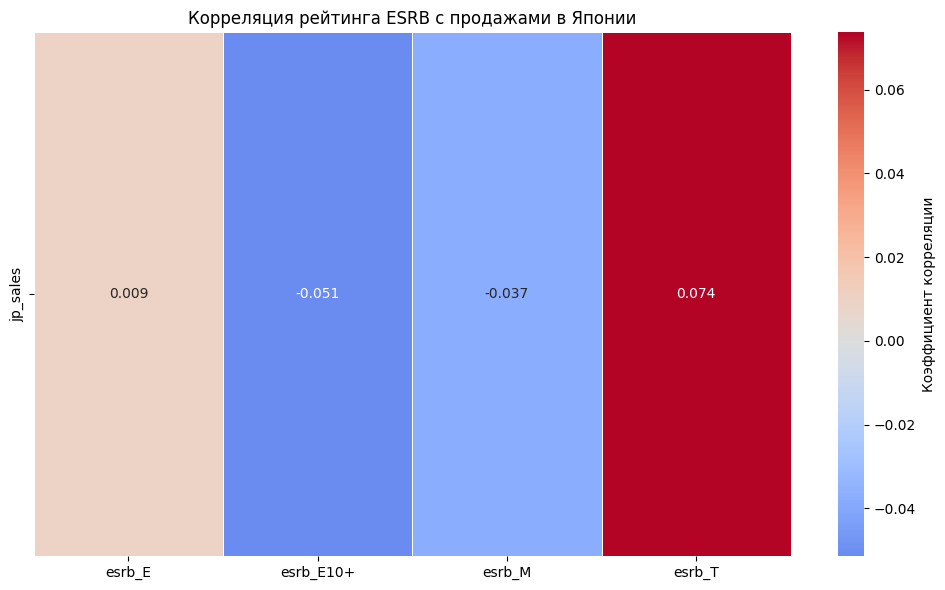

In [31]:
# избавимся от пропущенных значений
df_actual_esrb = df_actual.dropna(subset=['rating'])

# создадим dummy-переменные для рейтинга ESRB
esrb_dummies = pd.get_dummies(df_actual_esrb['rating'], prefix='esrb')

jp_corr = pd.concat([df_actual[['jp_sales']], esrb_dummies], axis=1)

# корриляция Пирсона для Японии
correlation_matrix_jp = jp_corr.corr()

# визуализируем показатели
plt.figure(figsize=(10, 6))
jp_corr = correlation_matrix_jp.loc['jp_sales', esrb_dummies.columns]
sns.heatmap(jp_corr.to_frame().T, 
           annot=True, cmap='coolwarm', center=0,
           fmt='.3f', linewidths=0.5, cbar_kws={'label': 'Коэффициент корреляции'})
plt.title('Корреляция рейтинга ESRB с продажами в Японии')
plt.tight_layout()
plt.show()


**Промежуточный вывод:**

Проведенный анализ корреляции между возрастными рейтингами ESRB и объемом продаж игр в Японии показал отсутствие статистически значимой связи. Все полученные коэффициенты корреляции находятся в диапазоне от -0,06 до 0,044, что свидетельствует о практически нулевой зависимости.

*Ключевые наблюдения:*

Наибольшая положительная корреляция наблюдается с рейтингом E (0,044), однако эта связь крайне слабая и не имеет практической значимости

Наибольшая отрицательная корреляция зафиксирована с рейтингом E10+ (-0,06)

Рейтинги M ("Для взрослых") и T ("Для подростков") демонстрируют практически нулевую корреляцию с продажами (-0,015 и 0,026 соответственно)

Основной вывод:
Возрастной рейтинг ESRB не является значимым фактором, влияющим на коммерческий успех игр на японском рынке. Это позволяет предположить, что японские потребители:

Руководствуются другими критериями при выборе игр (жанр, бренд, геймплейные особенности)

Могут ориентироваться на локальную систему рейтингов CERO вместо ESRB

Имеют культурно обусловленные предпочтения, не связанные с возрастными ограничениями

Рекомендация: При разработке и продвижении игр для японского рынка следует уделять первостепенное внимание другим факторам (жанровым предпочтениям, платформенной принадлежности, культурным особенностям), а не ориентироваться на возрастные рейтинги ESRB как на маркетинговый инструмент.

**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ:**


Проведенный комплексный анализ игрового рынка в трех ключевых регионах выявил фундаментальные различия в потребительском поведении, платформенных предпочтениях и жанровых пристрастиях. Эти различия носят системный характер и определяются культурными, историческими и рыночными особенностями каждого региона. Особенно показательным является полное отсутствие корреляции между возрастными рейтингами ESRB и продажами в Японии, что подчеркивает необходимость глубокой культурной адаптации продуктов для разных рынков.

**ДЕТАЛИЗИРОВАННЫЕ ПОРТРЕТЫ ПОЛЬЗОВАТЕЛЕЙ ПО РЕГИОНАМ**

1. СЕВЕРНАЯ АМЕРИКА - "КОНКУРЕНТНЫЙ УНИВЕРСАЛ"

Платформенные предпочтения: Сбалансированный рынок с лидерством Microsoft X360 (33,4%) при сильных позициях Sony PS3 (24,8%). Мультиплатформенность как ключевая характеристика.

Жанровый профиль: Явное предпочтение динамичных жанров - Action (33,6%), Shooter (25,3%) и Sports (15,8%). Отсутствие доминирования одного жанра свидетельствует о разнообразии вкусов.

Поведенческие особенности: Технологически ориентированный пользователь, ценящий конкурентный геймплей и графическое совершенство.

2. ЕВРОПА - "ТРАДИЦИОНАЛИСТ-АВТОЛЮБИТЕЛЬ"

Платформенные предпочтения: Четкое доминирование Sony (PS3 - 30,2%, PS4 - 26,2%) при уникальном для регионов присутствии PC (11,4%) в топ-5.

Жанровый профиль: Сохраняя интерес к Action (37,0%) и Shooter (27,5%), демонстрирует повышенное внимание к Racing (11,6%) и умеренный интерес к Role-Playing (7,5%).

Поведенческие особенности: Консервативный выбор платформ сочетается с ярко выраженным интересом к автомобильной тематике и спортивным симуляторам.

3. ЯПОНИЯ - "ПОРТАТИВНЫЙ СТОРИТЕЛЛЕР"

Платформенные предпочтения: Абсолютное лидерство портативных решений Nintendo 3DS (47,5%) при полном отсутствии продукции Microsoft. Сильные позиции Sony в сегменте портативных (PSP, PSV) и стационарных консолей.

Жанровый профиль: Кардинальное отличие от западных рынков - доминирование Role-Playing (43,0%) при полном отсутствии Shooter в топе. Значительная доля нишевых жанров (Fighting, Platform).

Ключевая особенность: Полное игнорирование возрастных рейтингов ESRB (корреляция от -0,06 до 0,044), что свидетельствует о приоритете других факторов при покупке.

Поведенческие особенности: Предпочтение портативного гейминга, ориентация на глубокие сюжеты и персонаже-ориентированные игры, сильная привязанность к локальным брендам.

СТРАТЕГИЧЕСКИЕ РЕКОМЕДАЦИИ:

Для достижения коммерческого успеха необходима глубокая региональная адаптация стратегий:

Северная Америка: Акцент на мультиплатформенность и конкурентные аспекты геймплея

Европа: Фокус на экосистему Sony и развитие автомобильно-спортивной тематики

Япония: Приоритет портативных платформ, RPG-жанра и полный пересмотр подхода к возрастному маркетингу




## ПРОВЕРКА ГИПОТЕЗ

Необходимо проверить две гипотезы и обосновать результаты:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

1. **Гипотеза:** средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**H0:** Средние пользовательские рейтинги платформ Xbox One и PC равны;  
**H1:** Средние пользовательские рейтинги платформ Xbox One и PC не равны.

Выборки независимы, поэтому для проверки гипотез будем использовать *Т-критерий Стьюдента*.

**Пороговое значение** = 0.05.

In [32]:
# избавимся от пропусков и сформируем выборки
x_one = df_actual[(df_actual['platform']=='XOne')&(df_actual['user_score']>=0)]
pc = df_actual[(df_actual['platform']=='PC')&(df_actual['user_score']>=0)]

x_one_score = x_one['user_score']
pc_score = pc['user_score']

# задаем пороговое значения и выполняем тест
alpha = 0.05
result = st.ttest_ind(x_one_score, pc_score)

# выводим результат
print('p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.10450507919348416
Не получилось отвергнуть нулевую гипотезу


2. **Гипотеза:** средние пользовательские оценки жанров Action и Sports разные.

**H0:** Средние оценки жанров Action и Sports равны;  
**H1:** Средние оценки жанров Action и Sports не равны.

Выборки снова независимы, поэтому использовать будем тест Стьюдента.

**Пороговое значение** = 0.05

In [33]:
# избавимся от пропусков и сформируем выборки
action = df_actual[(df_actual['genre']=='Action')&(df_actual['user_score']>=0)]
sports = df_actual[(df_actual['genre']=='Sports')&(df_actual['user_score']>=0)]

action_score = action['user_score']
sports_score = sports['user_score']

# задаем пороговое значения и проводим тест
alpha = 0.05
result = st.ttest_ind(action_score, sports_score)

# выводим результат
print('p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ:**

По результатам тестов можно сказать следующее: не получилось отвергнуть нулевую гипотезу о равенстве средних пользовательских оценок платформ Xbox One и PC. А нулевую гипотезу о равенстве средних оценок жанров Action и Sports - отвергаем.

## ОБЩИЙ ВЫВОД:

**Что было сделано:**

1. Были загруженны необходимые бибилиотеки
2. Датафрейм сохранен в переменной `df`
3. Исправленны названия столбцов (приведены к нижнему регистру)
4. Обработанны пропуски в данных
5. Исправление ошибок типизации данных
6. Посчитанна общая сумма продаж и сохранена в `total_sales`
7. Были устранены неявные дубликаты (явных дубликатов - необнаружено)
7. Был проведен ислледовательский анализ данных
8. Был составлен "портрет" пользователей по регионам
9. Были протестированы две гипотезы


**ВЫВОД ПО ИССЛЕДОВАНИЮ:**

**КОМПЛЕКСНЫЙ ВЫВОД ПО РЕЗУЛЬТАТАМ ИССЛЕДОВАНИЯ**

На основе проведенного анализа игрового рынка за период 2014-2016 годов можно сформулировать следующие ключевые выводы и стратегические рекомендации:

**1. Динамика рынка и жизненный цикл платформ**
- После пика выпуска игр в 2008 году (1427 игр) наблюдается устойчивый спад, к 2015 году показатель вернулся к уровню 2001 года
- Жизненный цикл игровых платформ составляет 4-5 лет, после чего коммерческая значимость снижается
- Для прогноза на 2017 год наиболее релевантны платформы в фазе роста/пика: PS4, XOne и 3DS
- PS4 и XOne демонстрируют наибольшую стабильность и способность регулярно выпускать успешные проекты

**2. Влияние оценок на коммерческий успех**
- Обнаружена слабая положительная корреляция между оценками критиков и продажами (r ≈ 0.4-0.5)
- Статистически значимой связи между пользовательскими оценками и продажами не выявлено
- Мнение профессиональных обозретелей имеет большее влияние на коммерческий успех, чем пользовательские рейтинги

**3. Жанровая экономика и региональные особенности**
- **Доминирующие жанры**: Action, Shooter и Sports показывают наибольшую коммерческую эффективность
- **Action** - максимальный охват рынка, идеален для максимизации прибыли
- **Shooter** - высокая стабильность продаж, минимальные риски
- **Sports** - сбалансированное сочетание объема и маржинальности
- **Региональная специфика** требует различных подходов:
  * Северная Америка: мультиплатформенность, акцент на конкурентный геймплей
  * Европа: доминирование Sony, популярность Racing-игр
  * Япония: лидерство портативных платформ, абсолютное доминирование RPG-жанра

**4. Структурные характеристики рынка**
- Рынок характеризуется "хитовой" экономикой: 80% продаж генерируют 20% проектов
- Медианные значения продаж составляют 200-500 тысяч копий на игру
- Наличие значительного количества выбросов (игры с продажами >1 млн копий) формирует основную выручку

**5. Статистические тесты и гипотезы**
- Не подтверждены различия в пользовательских оценках между платформами Xbox One и PC
- Подтверждены различия в оценках между жанрами Action и Sports
- Отсутствует корреляция между рейтингами ESRB и продажами в Японии

**СТРАТЕГИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ 2017 ГОДА:**

1. **Платформенная стратегия**: Фокус на PS4 и XOne как наиболее перспективные платформы
2. **Жанровый портфель**: Приоритет разработки игр в жанрах Action, Shooter и Sports
3. **Критический акцент**: Обеспечение высокого качества продукции для получения положительных оценок профессиональных обозретелей
4. **Региональная адаптация**:
   - Северная Америка: конкурентный мультиплатформенный подход
   - Европа: ориентация на экосистему Sony и развитие спортивной тематики
   - Япония: фокус на портативные платформы и RPG-жанр

Данное исследование демонстрирует, что успех на игровом рынке требует комплексного подхода, учитывающего жизненные циклы платформ, жанровые предпочтения, региональные особенности и корректную работу с профессиональным критическим сообществом.